In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib import pyplot as plt

In [154]:
SAMPLE_ORDER = list(range(530827))
np.random.shuffle(SAMPLE_ORDER)

In [2]:
points = pd.read_csv("../data/flowchart-data/charting-m-points.csv", encoding='unicode_escape')

/Users/damien/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,9,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
points

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,...,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
0,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,1,0,0,0.0,0.0,0-0,1 (1),1,0,...,NaN,False,False,False,False,False,False,1,1,1
1,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,2,0,0,0.0,0.0,15-0,1 (2),1,0,...,NaN,False,False,False,False,False,False,1,1,1
2,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,3,0,0,0.0,0.0,30-0,1 (3),1,0,...,1.0,False,False,False,True,False,False,1,1,1
3,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,4,0,0,0.0,0.0,40-0,1 (4),1,0,...,NaN,True,False,False,False,False,False,1,1,1
4,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,5,0,0,1.0,0.0,0-0,2 (1),1,0,...,1.0,False,False,False,False,True,False,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619642,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,247,2,2,4.0,3.0,0-40,46 (4),0,0,...,NaN,False,False,False,False,False,False,1,0,1
619643,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,248,2,2,5.0,3.0,0-0,47 (1),0,0,...,NaN,False,False,False,False,False,False,1,1,1
619644,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,249,2,2,5.0,3.0,15-0,47 (2),0,0,...,NaN,False,False,False,False,False,False,1,1,1
619645,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,250,2,2,5.0,3.0,30-0,47 (3),0,0,...,NaN,False,False,False,False,False,False,1,1,1


### plan

go through each match and keep a column for who won each individual point. also who was serving for each point. so make a separate table out of this and then we can try making one with features for the last 10, etc.

oh also we should keep a column for who was in the match

In [4]:
trimmed = points[points["match_id"] > "1991"][["match_id", "PtWinner", "isSvrWinner"]]
trimmed["p1Win"] = trimmed["PtWinner"] == 1
trimmed["isSvrWinner"] = trimmed["isSvrWinner"] == 1
trimmed["p1Served"] = trimmed["p1Win"] == trimmed["isSvrWinner"]
del(trimmed["PtWinner"])

In [5]:
points_dict = trimmed.to_dict("records")
points_dict

[{'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': True,
  'p1Served': True},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': True,
  'p1Served': True},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': True,
  'p1Served': True},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': True,
  'p1Served': True},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': False,
  'p1Win': True,
  'p1Served': False},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': False,
  'p1Win': True,
  'p1Served': False},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': False,
  'p1Win': True,
  'p1Served': False},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': False,
  'p1Served': 

In [6]:
current_match = ""
p1Win_p1Served = 0
p1Win_p2Served = 0
p2Win_p1Served = 0
p2Win_p2Served = 0
last5_p1Served = []
last5_p2Served = []

for p in points_dict:
  if p["match_id"] != current_match:
    p1Win_p1Served = 0
    p1Win_p2Served = 0
    p2Win_p1Served = 0
    p2Win_p2Served = 0
    last5_p1Served = [None] * 5
    last5_p2Served = [None] * 5
    current_match = p["match_id"]
  p["p1Win_p1Served"] = p1Win_p1Served
  p["p1Win_p2Served"] = p1Win_p2Served
  p["p2Win_p1Served"] = p2Win_p1Served
  p["p2Win_p2Served"] = p2Win_p2Served
  p["p1Served1"] = last5_p1Served[-1]
  p["p1Served2"] = last5_p1Served[-2]
  p["p1Served3"] = last5_p1Served[-3]
  p["p1Served4"] = last5_p1Served[-4]
  p["p1Served5"] = last5_p1Served[-5]
  p["p2Served1"] = last5_p2Served[-1]
  p["p2Served2"] = last5_p2Served[-2]
  p["p2Served3"] = last5_p2Served[-3]
  p["p2Served4"] = last5_p2Served[-4]
  p["p2Served5"] = last5_p2Served[-5]
  if p["p1Served"]:
    last5_p1Served.append(p["p1Win"])
    p1Win_p1Served += p["p1Win"]
    p2Win_p1Served += not p["p1Win"]
    last5_p1Served.pop(0)
  else:
    last5_p2Served.append(p["p1Win"])
    p1Win_p2Served += p["p1Win"]
    p2Win_p2Served += not p["p1Win"]
    last5_p2Served.pop(0)

In [7]:
with_last5 = pd.DataFrame.from_dict(points_dict)
with_last5

,match_id,isSvrWinner,p1Win,p1Served,p1Win_p1Served,p1Win_p2Served,p2Win_p1Served,p2Win_p2Served,p1Served1,p1Served2,p1Served3,p1Served4,p1Served5,p2Served1,p2Served2,p2Served3,p2Served4,p2Served5
0,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,True,True,0,0,0,0,None,None,None,None,None,None,None,None,None,None
1,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,True,True,1,0,0,0,True,None,None,None,None,None,None,None,None,None
2,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,True,True,2,0,0,0,True,True,None,None,None,None,None,None,None,None
3,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,True,True,3,0,0,0,True,True,True,None,None,None,None,None,None,None
4,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,False,True,False,4,0,0,0,True,True,True,True,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574313,19910125-M-Australian_Open-SF-Stefan_Edberg-Iv...,True,False,False,104,60,56,100,True,True,True,True,True,True,False,False,False,False
574314,19910125-M-Australian_Open-SF-Stefan_Edberg-Iv...,True,False,False,104,60,56,101,True,True,True,True,True,False,True,False,False,False
574315,19910125-M-Australian_Open-SF-Stefan_Edberg-Iv...,False,True,False,104,60,56,102,True,True,True,True,True,False,False,True,False,False
574316,19910125-M-Australian_Open-SF-Stefan_Edberg-Iv...,True,False,False,104,61,56,102,True,True,True,True,True,True,False,False,True,False


In [8]:
with_last5 = with_last5.dropna(axis=0, how="any")

In [9]:
serve_agg = with_last5.groupby("match_id").max(["p1Win_p1Served", "p2Win_p1Served", "p1Win_p2Served", "p2Win_p2Served"])

In [10]:
serve_sums = serve_agg[["p1Win_p1Served", "p2Win_p1Served", "p1Win_p2Served", "p2Win_p2Served"]].sum()

the serving player wins about 64% of the time, basically

In [11]:
(serve_sums[0] + serve_sums[3]) / sum(serve_sums)

0.6411745645301129

In [263]:
win_pct = with_last5.copy()
win_pct["pct_p1Served"] = (win_pct["p1Win_p1Served"] + 32) / (win_pct["p1Win_p1Served"] + win_pct["p2Win_p1Served"] + 50.0)
win_pct["pct_p2Served"] = (win_pct["p1Win_p2Served"] + 18) / (win_pct["p1Win_p2Served"] + win_pct["p2Win_p2Served"] + 50.0)
del(win_pct["p1Win_p1Served"])
del(win_pct["p2Win_p1Served"])
del(win_pct["p1Win_p2Served"])
del(win_pct["p2Win_p2Served"])

In [264]:
win_pct_np = win_pct.iloc[:, 1:].to_numpy("float")[SAMPLE_ORDER]

In [265]:
y = win_pct_np[:, 1]
x_seq = win_pct_np[:, 2:]
x_no_seq = win_pct_np[:, [2, 13, 14]]

In [266]:
server_wins = win_pct_np.copy()
server_wins[win_pct_np[:, 2] == 0] = 1 - server_wins[win_pct_np[:, 2] == 0][:, list(range(0, 3)) + list(range(8, 13)) + list(range(3, 8)) + [14, 13]]
server_wins

array([[1.        , 0.        , 1.        , ..., 1.        , 0.64705882,
        0.34090909],
       [0.        , 0.        , 1.        , ..., 1.        , 0.69014085,
        0.35460993],
       [1.        , 1.        , 1.        , ..., 1.        , 0.62765957,
        0.33766234],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 0.58666667,
        0.33783784],
       [0.        , 0.        , 1.        , ..., 0.        , 0.66197183,
        0.3015873 ],
       [1.        , 0.        , 1.        , ..., 0.        , 0.62773723,
        0.35714286]])

In [267]:
X = server_wins[:, 3:]
y = server_wins[:, 1]
np.mean(X, axis=0)

array([0.64195868, 0.64257282, 0.64291756, 0.64326419, 0.64383688,
       0.20856324, 0.29878849, 0.35249337, 0.34800415, 0.37102295,
       0.64149364, 0.35537141])

the first two are your accuracy with all the features. the middle two are your accuracy only knowing each player's win % so far on points they've served. the last two are your accuracy only knowing the outcomes of the last 5 points each player has served.

In [288]:
linear_seq = LinearRegression().fit(X[:400000], y[:400000])
linear_no_seq = LinearRegression().fit(X[:400000, 10:], y[:400000])
linear_only_last5 = LinearRegression().fit(X[:400000, :10], y[:400000])
log_seq = LogisticRegression().fit(X[:400000], y[:400000])
log_no_seq = LogisticRegression().fit(X[:400000, 10:], y[:400000])
log_only_last5 = LogisticRegression().fit(X[:400000, :10], y[:400000])

(
  np.mean(np.square(y[400000:] - log_seq.predict_proba(X[400000:, ])[:, 1])),
  np.mean(np.square(y[400000:] - linear_seq.predict(X[400000:, ]))),
  np.mean(np.square(y[400000:] - log_no_seq.predict_proba(X[400000:, 10:])[:, 1])),
  np.mean(np.square(y[400000:] - linear_no_seq.predict(X[400000:, 10:]))),
  np.mean(np.square(y[400000:] - linear_only_last5.predict(X[400000:, :10]))),
  np.mean(np.square(y[400000:] - log_only_last5.predict(X[400000:, :10])))
)
  

(0.2277932988444095,
 0.22778949671791016,
 0.22786083725121564,
 0.22785507027067525,
 0.22897083280822425,
 0.3572427709876402)

for comparison: your accuracy if you only know who serves

In [273]:
np.square((1 - np.mean(y[:400000]))) * np.mean(y[400000:]) + np.square(np.mean(y[:400000])) * (1 - np.mean(y[400000:]))

0.2296244025330207

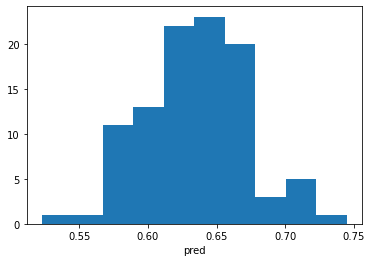

In [289]:
plt.hist(log_seq.predict_proba(X)[:100, 1])
plt.xlabel("pred")
plt.savefig("../plots/logseq.png")

In [283]:
print(np.array2string(linear_seq.coef_, precision=5, suppress_small=True))

[0.01071 0.00848 0.00415 0.00258 0.00419 0.00554 0.00096 0.00038 0.00259
 0.00085 0.90158 0.14833]


### TA meeting feedback

in presentation: list our variables both mathematically and in language

add more features and see if that boosts performance

try adding a "# of points played in match" feature (normalized)

try LASSO or ridge regression?